In [1]:
# package imports
#basics
import numpy as np
import pandas as pd

#misc
import gc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

# graph viz
import plotly.offline as pyo
from plotly.graph_objs import *
import plotly.graph_objs as go

#map section
import imageio
import folium
import folium.plugins as plugins
#from mpl_toolkits.basemap import Basemap


#graph section
import networkx as nx
import heapq  # for getting top n number of things from list,dict


#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")
pyo.init_notebook_mode()

%matplotlib inline

In [2]:
yelp_reviews=pd.read_csv("yelp_review.csv",usecols=["stars","text"], nrows = 100000)
yelp_reviews.head(5)

stars                                               text
0      5  Super simple place but amazing nonetheless. It...
1      5  Small unassuming place that changes their menu...
2      5  Lester's is located in a beautiful neighborhoo...
3      4  Love coming here. Yes the place always needs t...
4      4  Had their chocolate almond croissant and it wa...

In [3]:
#let's check out a sample review
yelp_reviews.text[7]

'Always drove past this coffee house and wondered about it. BF and I finally made the stop to try this place out.\n\nCute, quaint coffee shop with nice muskoka chairs outside. \n\nBF ordered an ice coffee and really enjoyed it! Guess we will be back again!'

In [4]:
##checking for nulls
yelp_reviews.isnull().any()


stars    False
text     False
dtype: bool

In [5]:
yelp_reviews.stars.unique()

array([5, 4, 3, 1, 2], dtype=int64)

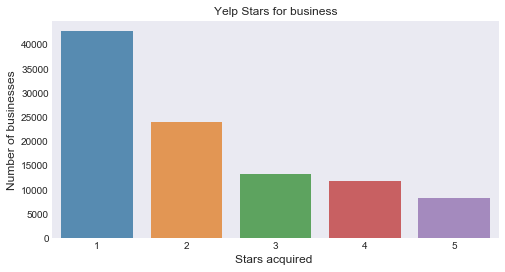

In [6]:
x=yelp_reviews['stars'].value_counts()
y=x.sort_index()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(y.index, x.values, alpha=0.8)
plt.title("Yelp Stars for business")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Stars acquired ', fontsize=12);
plt.savefig("rating.png",dpi=300)

In [7]:
reviews=yelp_reviews[:]
reviews=reviews[reviews.stars!=3]

reviews["labels"]= reviews["stars"].apply(lambda x: 1 if x > 3  else 0)
reviews=reviews.drop("stars",axis=1)

reviews.head()

text  labels
0  Super simple place but amazing nonetheless. It...       1
1  Small unassuming place that changes their menu...       1
2  Lester's is located in a beautiful neighborhoo...       1
3  Love coming here. Yes the place always needs t...       1
4  Had their chocolate almond croissant and it wa...       1

In [8]:
texts = reviews["text"].values
labels = reviews["labels"].values

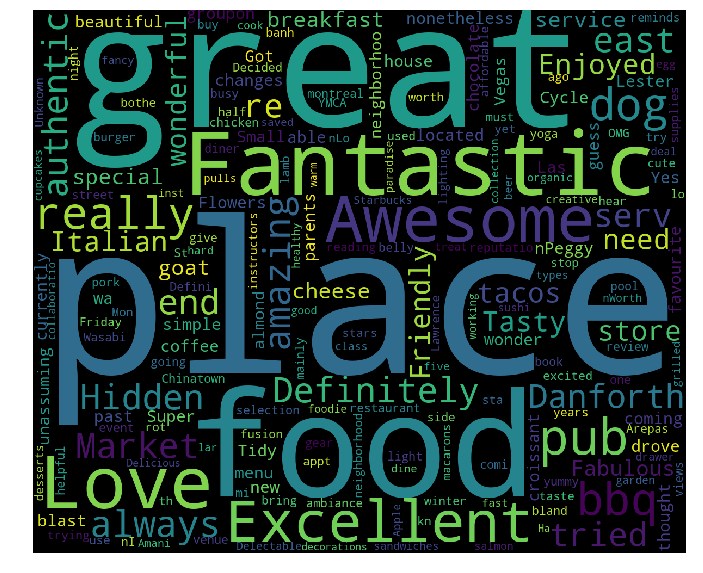

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

plt.figure(figsize=(12,10))

wordcloud = WordCloud(background_color='black',
                          width=1200,
                      stopwords = STOPWORDS,
                          height=1000
                         ).generate(str(reviews['text']))


plt.imshow(wordcloud)
plt.axis('off');
plt.savefig("WC_2.png",dpi=300)

In [10]:
import keras
from keras.utils import to_categorical
from keras.preprocessing import text
MAX_NUM_WORDS=1000 # how many unique words to use (i.e num rows in embedding vector)
MAX_SEQUENCE_LENGTH=100 # max number of words in a review to use


tokenizer = text.Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = keras.preprocessing.sequence.pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
word_length = len(word_index)+1

Using TensorFlow backend.


Found 88763 unique tokens.
Shape of data tensor: (88192, 100)
Shape of label tensor: (88192, 2)


In [11]:
VALIDATION_SPLIT=0.2

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]

In [12]:
GLOVE_DIR='glove-global-vectors-for-word-representation/'

import os
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding = "utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [13]:
EMBEDDING_DIM = 100 # how big is each word vector

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [14]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [15]:
#Keras Linrary
from keras.models import Model
from keras.models import Sequential
from keras.layers import Bidirectional, GlobalMaxPool1D,Conv1D, MaxPooling1D, SimpleRNN, GRU
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          8876400   
_________________________________________________________________
gru_1 (GRU)                  (None, 24)                9000      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 8,888,102
Trainable params: 8,888,102
Non-trainable params: 0
_________________________________________________________________
None
Train on 70554 samples, validate on 17638 samples
Epoch 1/3
70554/70554 [==============================] - 115s 2ms/step - loss

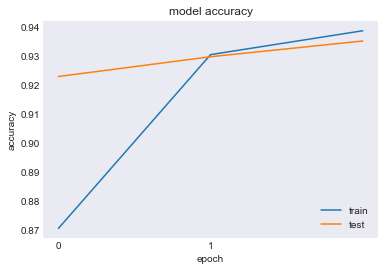

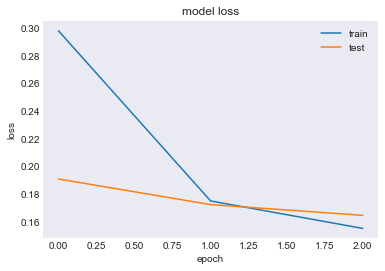

In [16]:
# GRU model analysis

model = Sequential()
model.add(Embedding(word_length, 100, weights=[embedding_matrix], input_length=100))
model.add(GRU(24, activation='relu', use_bias=True, kernel_initializer='glorot_uniform'))
#model.add(GlobalMaxPool1D())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


# fit the model

#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_GRU', histogram_freq=1, write_graph=True, write_images=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=128) #, callbacks=[tbCallBack])

print(history.history.keys())
# summarize history for accuracy

# Plots for training and testing process: loss and accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])  # RAISE ERROR
plt.xticks(np.arange(0,2,step=1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.savefig ("GRU_Acc.png",dpi=300)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #RAISE ERROR
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig ("GRU_Loss.png",dpi=600)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          8876400   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 872       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                450       
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 102       
Total params: 8,877,824
Trainable params: 8,877,824
Non-trainable params: 0
_________________________________________________________________
None
Train on 70554 samples, validate on 17638 samples
Epoch 1/3
70554/70554 [==============================] - 55s 778us/step - los

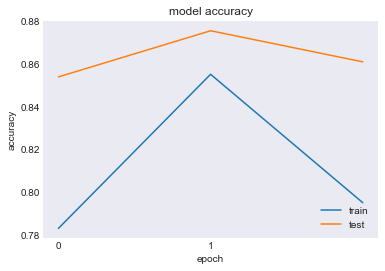

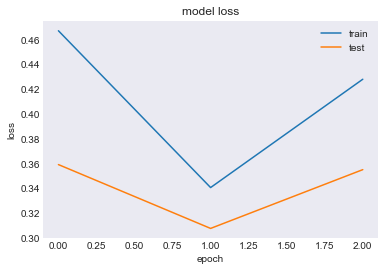

In [17]:
# RNN model analysis

model = Sequential()
model.add(Embedding(word_length, 100, weights=[embedding_matrix], input_length=100))
model.add(SimpleRNN(8, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform'))
#model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

# fit the model

#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_RNN', histogram_freq=1, write_graph=True, write_images=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=128) # , callbacks=[tbCallBack])

print(history.history.keys())
# summarize history for accuracy

# Plots for training and testing process: loss and accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])  # RAISE ERROR
plt.xticks(np.arange(0,2,step=1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.savefig ("RNN_Acc.png",dpi=300)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #RAISE ERROR
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig ("RNN_Loss.png",dpi=600)
plt.show()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          8876400   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 150)               15150     
_________________________________________________________________
dropout_3 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 302       
Total params: 8,891,852
Trainable params: 15,452
Non-trainable params: 8,876,400
_________________________________________________________________
None
Train on 70554 samples, validate on 17638 samples
Epoch 1/3
70554/70554 [==============================] - 5s 69us/step - 

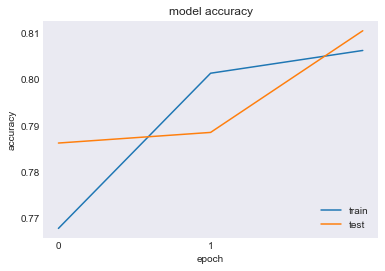

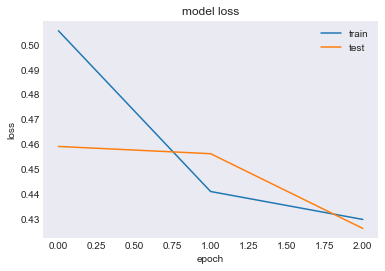

In [18]:
# Multilayer Perceptron model analysis

model = Sequential()
y = Embedding(word_length, 100, weights=[embedding_matrix], input_length=100, trainable=False)
model.add(y)
model.add(GlobalMaxPool1D())
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
print(model.summary())
# fit the model
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_MP', histogram_freq=1, write_graph=True, write_images=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=128) #, callbacks=[tbCallBack])



print(history.history.keys())
# summarize history for accuracy

# Plots for training and testing process: loss and accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])  # RAISE ERROR
plt.xticks(np.arange(0,2,step=1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.savefig ("MP_Acc.png",dpi=300)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #RAISE ERROR
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig ("MP_Loss.png",dpi=600)
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 100)          8876400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 150)               15150     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 302       
Total para

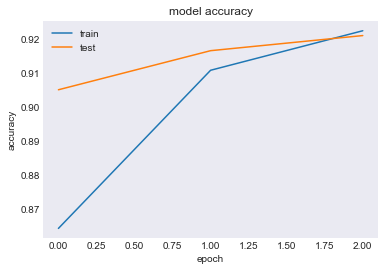

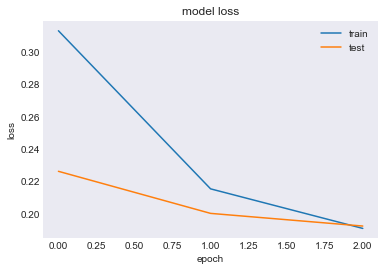

In [19]:
# LSTM model analysis

inp = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedded_sequences = embedding_layer(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(150, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print (model.summary())
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph_LSTM', histogram_freq=1, write_graph=True, write_images=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=3, batch_size=128) #, callbacks=[tbCallBack])

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])  # RAISE ERROR
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig ("LSTM_Acc.png",dpi=600)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) #RAISE ERROR
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig ("LSTM_Loss.png",dpi=600)
plt.show()